---

# CSCI 3202, Spring 2022
# Homework 2
# Due: Wednesday, February 15 at 9:00 pm

<br> 

### Drake Morley

<br> 

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq

# Sets random seeds for reproducibility
SEED=42
random.seed(SEED)
np.random.seed(SEED)

## Problem 1

### Discrete Robot Path Planning

A robotics group at CU needs some help designing a path planning algorithm that can navigate around the engineering center. To get started they have designed two test environments for you to implement breadth-first, depth-first, and uniform-cost search.

- In the first environment, every movement to an adjacent cell has a cost of 1. The first environment will be represented by the `edge_weights_1` dictionary. 

- In the second enviornment, traveling to adjacent cells has a random int cost between 1 and 100. The second environment will be represented by the `edge_weights_2` dictionary. 

- Both setups have the same obstacles, free space, and goal. The code below creates and gives a visual representation of the robot's environment. 

- The first figure shows the environment itself with free spaces, barriers, robot start, and goal point. 

- The second image shows an example of what a path might look like as the robot moves through the environment.

### Color representation
yellow = obstacle

teal = free space

pink = goal

grey = robot start

red = part of the path

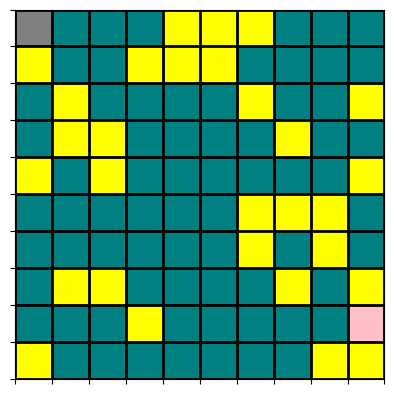

In [13]:
# Given code
def show_path(env, path):
    """Generates a matplotlib visual of thethe path in the env grid."""
    env_copy = np.copy(env)
    for cell in path:
        if(env_copy[cell[0]][cell[1]] >= 5 and env_copy[cell[0]][cell[1]] < 20):
            env_copy[cell[0]][cell[1]] = 41
    show_env(env_copy)
    

def show_env(env):
    """Generates a matplotlib visual of the env grid, where colors represent 
    the start node (grey), end node (pink), an obstacle (yellow), 
    an open node (teal), or part of the path found by a search algorithm (red)."""
    cmap = colors.ListedColormap(['yellow', 'teal', 'pink', 'grey', 'red'])
    bounds = [0,5,20,30,40,41]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(env, cmap=cmap, norm=norm)
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, 10, 1));
    ax.set_yticks(np.arange(-.5, 10, 1));
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    plt.show()


env = np.random.rand(10, 10) * 20
#set robot start position, grey color spot
start = (0, 0)
env[start[0]][start[1]] = 31
#set goal position pink square
goal = (8, 9)
env[goal[0]][goal[1]] = 21
# show the original graph
show_env(env)

# show an example path in the original graph, not a valid path
# example_path = [(1,1), (2,2), (3,3), (4,4), (5,4), (6,4), (7,4), (8,4), (8,5),(8,6),(8,7),(8,8)]
# show_path(env, example_path)

### Graph Representation
We represent the graph above as an adjacency dict in the following code. You can see what edges any cell has by indexing into the two dicts: 
- `edge_weights_1`
- `edge_weights_2`

For indexing, the top left of the graph is (row=0, col=0). Row values increase downward and column values increase to the right. 

So for example, if you wanted to look at the pink cell's (the goal location) connections you can call `print(edge_weights_2[(8,9)])` 

In [14]:
# create dictionary
edge_weights_1 = {}
edge_weights_2 = {}

# Builds both graphs.
for row, row_vals in enumerate(env):
    for col, val in enumerate(env[row]):
        # create dictionary
        edge_weights_1[(row, col)] = {}
        edge_weights_2[(row, col)] = {}
        #set all 6 direction options in edge_wights
        # 1) up
        if(row > 0):
            edge_weights_1[(row, col)][(row-1, col)] = 1
            edge_weights_2[(row, col)][(row-1, col)] = np.random.randint(101)
            if(col > 0):
                edge_weights_1[(row, col)][(row-1, col-1)] = 1
                edge_weights_2[(row, col)][(row-1, col-1)] = np.random.randint(101)
            if(col < 9):
                edge_weights_1[(row, col)][(row-1, col+1)] = 1
                edge_weights_2[(row, col)][(row-1, col+1)] = np.random.randint(101)
        #2) left
        if(col > 0):
            edge_weights_1[(row, col)][(row, col-1)] = 1
            edge_weights_2[(row, col)][(row, col-1)] = np.random.randint(101)
            if(row < 9):
                edge_weights_1[(row, col)][(row+1, col-1)] = 1
                edge_weights_2[(row, col)][(row+1, col-1)] = np.random.randint(101)
        #3) down 
        if(row < 9):
                edge_weights_1[(row, col)][(row+1, col)] = 1
                edge_weights_2[(row, col)][(row+1, col)] = np.random.randint(101)
                if(col < 9): 
                    edge_weights_1[(row, col)][(row+1, col+1)] = 1
                    edge_weights_2[(row, col)][(row+1, col+1)] = np.random.randint(101)
        #) right
        if(col < 9):
                edge_weights_1[(row, col)][(row, col+1)] = 1
                edge_weights_2[(row, col)][(row, col+1)] = np.random.randint(101)

for first_node in list(edge_weights_2.keys()):
    for second_node in list(edge_weights_2[first_node].keys()):
        
        # if first_node is yellow (an obstacle) the connection going both ways should be removed
        if(env[first_node[0]][[first_node[1]]] < 5):
            edge_weights_2[first_node].pop(second_node)
            edge_weights_2[second_node].pop(first_node)
            edge_weights_1[first_node].pop(second_node)
            edge_weights_1[second_node].pop(first_node)
        # if there is a connection, make sure both edges are the same
        else:
            w1 = edge_weights_2[first_node][second_node]
            w2 = edge_weights_2[second_node][first_node]
            if(w1 != w2):
                edge_weights_2[first_node][second_node] = edge_weights_2[second_node][first_node]
                
                
# These represent the same location
print('goal:   ', edge_weights_2[goal])
print('(8, 9): ', edge_weights_2[(8,9)])

goal:    {(7, 8): 46, (8, 8): 24}
(8, 9):  {(7, 8): 46, (8, 8): 24}


### Useful helper routines for searching


In [15]:
def path(previous, s): 
    """
    previous (Dict): Dictionary chaining together the predecessor state that led to each state
        `s` will be None for the initial state.
        otherwise, starts from the last state `s` and recursively traces `previous` back to the initial state,
        constructing a list of states visited as we go.
    """
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]


def pathcost(path, step_costs):
    """
    Adds up the step costs along a path, which is assumed to be a list output 
    from the `path` function above.
    """
    cost = 0
    for s in range(len(path)-1):
        cost += step_costs[path[s]][path[s+1]]
    return cost

In [16]:
def check_map(step_costs):
    """Checks if all the path costs are at least symmetric."""
    check_states = []
    for state1 in step_costs.keys():
        for state2 in step_costs[state1].keys():
            uh_oh = step_costs[state2][state1]!=step_costs[state1][state2]
            if uh_oh:
                print('Check the costs between states {} and {}'.format(state1,state2))
                check_states.append([state1,state2])
    if len(check_states)==0:
        print('all okay! (symmetric at least)')
    return check_states

---
### (1a)

#### Breadth-first search

Implement a function **breadth_first(start, goal, state_graph, return_cost)** to search the state space defined by the **state_graph** using breadth-first search:
* **start** (Tuple[int, int]): initial state (e.g., '(0,0)' or `start`)
* **end** (Tuple[int, int]): goal state (e.g., '(8,9)' or `goal`)
* **state_graph** (Dict[Tuple[int, int], Dict[Tuple[int, int], float]]): the dictionary defining the edge costs (e.g., `edge_weights_1` or `edge_weights_2`)
* **return_cost** (bool): logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path as tuples (row, col) and the second value is the path cost
  * If **False**, then the only output is the solution path list object

Note that in the helper functions above, two useful routines for obtaining your solution path are provided (and can be used for all the search algorithms):
  * **path(previous, s)**: returns a list representing a path to state **s**, where **previous** is a dictionary that maps predecessors (values) to successors (keys)
  * **pathcost(path, step_costs)**: adds up the step costs defined by the **step_costs** graph (e.g., `edge_weights_2`) along the list of states **path**

In [17]:
# Your code here:
#refferenced from
#https://favtutor.com/blogs/breadth-first-search-python
def breadth_first(start, goal, state_graph, return_cost=False):
    que = list()
    visited  = list()
    tracker = {}
    

    que.append(start)
    visited.append(start)
    """Finds a shortest sequence of states from start to the goal using BFS.
    
    Args:
        start (Tuple): The coordinates for the start node
        goal (Tuple): The coordinates for the goal node
        state_graph (Dict): The graph to search.
        return_cst (bool): Whether or not the cost of the path should also be returned.
            Default: False
            
    Returns:
        The List of nodes in the shortest path, and potentially the cost (List, Optional(float))
    """


    print("path from using DFS", start, " to ", goal)
    while que:
        m = que.pop(0)

        if m == goal:
            TBR = path(tracker, goal)
            if return_cost:
                return (TBR, pathcost(TBR, state_graph) )
            else:
                return TBR
            print("you have reached the goal but something went wrong")
            return
        
        if m == start:
            tracker[m] = None
        
        for neighbor in state_graph[m]:
            if neighbor not in visited:
                tracker[neighbor] = m
                visited.append(neighbor)
                que.append(neighbor)
        
        



    
    
    


In [18]:
print (breadth_first((0,0), (8,9), edge_weights_2 , return_cost=False))

path from using DFS (0, 0)  to  (8, 9)
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 4), (6, 5), (7, 6), (6, 7), (7, 8), (8, 9)]


---
### (1b)

#### Uniform-cost search

First, let's create our own `Frontier_PQ` class to represent the frontier (priority queue) for uniform-cost search.  Note that the [`heapq`](https://docs.python.org/3/library/heapq.html) package is imported in the helpers at the bottom of this notebook; you may find that package useful.  You could also use the `Queue` package.  Your implementation of the uniform-cost search frontier should adhere to these specifications:
* Instantiation arguments: 
  * **Frontier_PQ(start, cost)**
  * **start** (Tuple[int, int]): is the initial state (e.g., **start**=(0,0) or `start`)
  * **cost** (float): is the initial path cost (what should it be for the initial state?)
* Instantiation attributes/methods:
  * **states** (Dict[Tuple[int, int], float]): maintains a dictionary of states on the frontier, along with the _minimum_ path cost to arrive at them
  * **q** (List[Tuple[float, Tuple[int, int]]]): a list of (cost, state) tuples, representing the elements on the frontier; should be treated as a priority queue (in contrast to the **states** dictionary, which is meant to keep track of the lowest-cost to each state)
  * appropriately initialize the starting state and cost
* Methods to implement:
  * **add(state, cost)**: add the (cost, state) tuple to the frontier
  * **pop()**: return the lowest-cost (cost, state) tuple, and pop it off the frontier
  * **replace(state, cost)**: if you find a lower-cost path to a state that's already on the frontier, it should be replaced using this method.
  
Note that there is some redundancy between the information stored in **states** and **q**. We only suggest to code it in this way because we think it's the most straightforward way to get something working. You could reduce the storage requirements by eliminating the redundancy, but it increases the time complexity because of the function calls needed to manipulate your priority queue to check for states (since that isn't how the frontier queue is ordered).

In [19]:
import heapq

In [20]:
# Your code here:

class Frontier_PQ:
    """Frontier class for uniform search, ordered by path cost."""
    q = []
    states = {}
    def __init__(self, start, cost):
        """Initializes the attributes `q` and `states`
        
        q is a List, and states is a Dict. Each should be intialized with the start node."""
        self.states[start] = cost
        heapq.heappush(self.q,(cost,start))
        
    def add(self, state, cost):
        """Pushes the new state and cost to get there onto the heap.
        
        Be sure to use `heapq`."""
        heapq.heappush(self.q,(cost,state))
        self.states[state] = cost

    def pop(self):
        """Pops the lowest cost state from the `q`, and the `states` Dict."""
        return heapq.heappop(self.q)

    def replace(self, state, cost):
        """Replaces old `cost` with new `cost` iff old `cost` < new `cost`.
        This method maintains the heap invariant of `q`."""
        if cost < self.states[state]:
            counter = 0
            for item in self.q:
                if item[1] == state:
                    self.states[state] = cost
                    self.q.pop(counter)
                    self.add(state,cost)
                    return
                counter+=1
    

            
        
        


Now, actually implement a function to search using `uniform_cost` search, called as **uniform_cost(start, goal, state_graph, return_cost)**:
* **start**: initial state
* **goal**: goal state
* **state_graph**: graph representing the connectivity and step costs of the state space (e.g., **edge_weights_1** or **edge_weights_2**)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

In [21]:
# Your code here:

def uniform_cost_search(start, goal, state_graph, return_cost):

    fringe = Frontier_PQ(start, 0)
    visited = list()
    breadCrumbs = {start:None}
    nodesExplored = {}

    while fringe:

        current = fringe.pop()
        stateeee = current[1]


        
        if stateeee == goal:
            if return_cost:
                return (path(breadCrumbs, stateeee),current[0])
            else:
                return path(breadCrumbs, stateeee)




        nodesExplored[stateeee] = current[0]

        for state in state_graph[stateeee]:


            cost = nodesExplored[stateeee] + state_graph[stateeee][state]
            if (state not in fringe.states):
                    if (state not in nodesExplored):
                        fringe.add(state,cost)
                        breadCrumbs[state]=stateeee
            else:
                if (state in fringe.states):
                    if( cost < fringe.states[state]):
                        fringe.replace(state,cost)
                        breadCrumbs[state]=stateeee
   

---

### (1c)

In the code cell below, for each of the two search algorithms defined above (in **1a** and **1b**), display the following information to the screen:

First, use `edge_weights_1`:
1) Print the path from start to goal 
2) Print the total cost of that path
3) Use the `show_path(env, path)` function to showcase the output your search algorithm. 

Second, use `edge_weights_2`:
1) Print the path from start to goal 
2) Print the total cost of that path
3) Use the `show_path(env, path)` function to showcase the output your search algorithm. 


Then, in a markdown cell below your code cell, write a few sentences:
* Which algorithm yields the shortest path for both edge weights?
* Does this surprise you? Or is this your expected result?

10


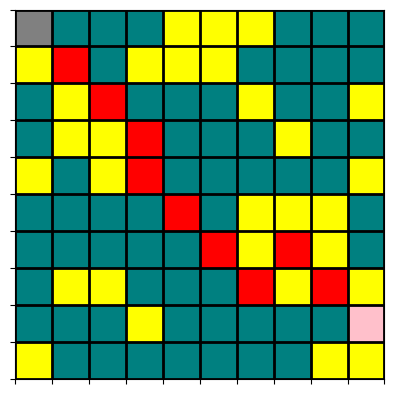

path from using DFS (0, 0)  to  (8, 9)
10


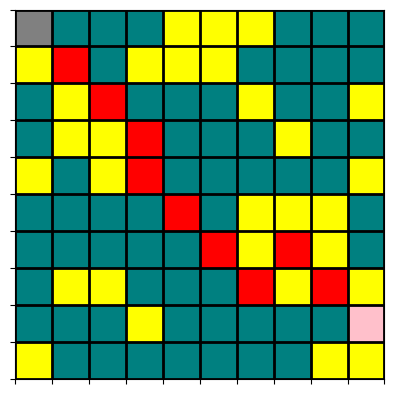

In [22]:
start = (0,0)
goal = (8,9)
graph = edge_weights_1

foo,cost = uniform_cost_search(start, goal, graph , return_cost=True)
print(cost)
show_path(env, foo)
pather,cost = breadth_first(start, goal, graph , return_cost=True)
print(cost)
show_path(env, pather)


In [23]:
# I seem to have bungled my global variables somewhere so this is required.
class Frontier_PQ:
    """Frontier class for uniform search, ordered by path cost."""
    q = []
    states = {}
    def __init__(self, start, cost):
        """Initializes the attributes `q` and `states`
        
        q is a List, and states is a Dict. Each should be intialized with the start node."""
        heapq.heappush(self.q,(cost,start))
        self.states[start] = cost
        
    def add(self, state, cost):
        """Pushes the new state and cost to get there onto the heap.
        
        Be sure to use `heapq`."""
        heapq.heappush(self.q,(cost,state))
        self.states[state] = cost

    def pop(self):
        """Pops the lowest cost state from the `q`, and the `states` Dict."""
        (cost, state) = heapq.heappop(self.q)
        self.states.pop(state)
        return (cost,state)

    def replace(self, state, cost):
        """Replaces old `cost` with new `cost` iff old `cost` < new `cost`.
        This method maintains the heap invariant of `q`."""
        if cost < self.states[state]:
            counter = 0
            for item in self.q:
                if item[1] == state:
                    self.states[state] = cost
                    self.q.pop(counter)
                    self.add(state,cost)
                    return
                counter+=1

def path(previous, s): 
    """
    previous (Dict): Dictionary chaining together the predecessor state that led to each state
        `s` will be None for the initial state.
        otherwise, starts from the last state `s` and recursively traces `previous` back to the initial state,
        constructing a list of states visited as we go.
    """
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

217


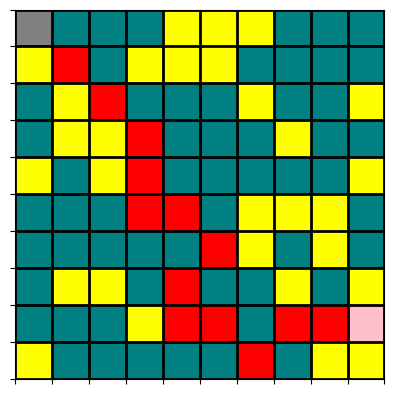

path from using DFS (0, 0)  to  (8, 9)
390


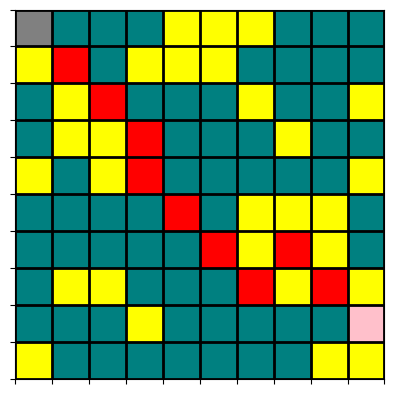

In [24]:
# Next we show the solution paths for edge_weights_2
start = (0,0)
goal = (8,9)
graph = edge_weights_2

foo,cost = uniform_cost_search(start, goal, graph , return_cost=True)
print(cost)
show_path(env, foo)

pather,cost = breadth_first((0,0), (8,9), edge_weights_2 , return_cost=True)
print(cost)
show_path(env, pather)


Which algorithm yields the shortest path for both edge weights?\
The Uniform cost algorithum!\
Does this surprise you? Or is this your expected result?\
This is the expected result. The uniform cost should work to find the least cost path where as breath first will wind the path with the fewest itterations. Thus while the breath first seems to be a shorter path it costs less still.

## Problem 2: A*
Use the graph below to go through the A* algorithm by hand to determine the path that should be taken from $S$ to $G$. Heuristic values are shown in red above each node. Step costs between nodes are shown near each respective edge in black.

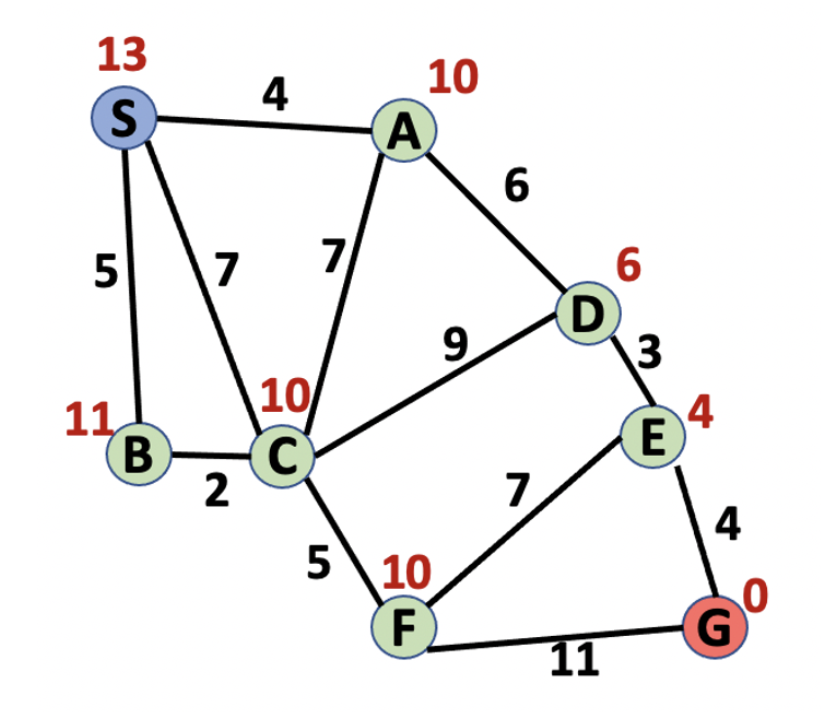

Fill in the table below (that is, add the necessary rows) to show the updated explored set and frontier with each iteration. The first iteration is done for you so that you can see the notation that is expected. If there are any ties, break them in alphabetical order.

| Explored Nodes | Frontier Nodes/Paths & f values  |
| :- | -: |
| $ $ | $(S,13)$ |
| $S$ | $(A,14), (B,16), (C,17)$ |
| $S,A$| $(D,12), (B,16), (C,17)$|
| $S,A,D$| $(E,7), (B,16), (C,17)$|
| $S,A,D,E$| $(G,4), (F,17), (B,16), (C,17)$|
| $S,A,D,E,G$| $(F,17), (B,16), (C,17)$|

### 2(a) - robot path planning

Using the robot environment in Problem 1, implement the A* algorithm using a Euclidean distance heuristic. In this implementation $h(n) = \sqrt{(x_g - x_n)^2 + (y_g - y_n)^2}$. In this equation; $x_g$ and $x_n$ represent the column location of goal and current node, repectively. The variables $y_g$ and $y_n$ are the row values of each node.

Run your code and display the results visually using the `show_path` method.



In [25]:
#A* code goes here
import math
def a_star(start, goal, state_graph, return_cost=False):

    fringe = Frontier_PQ(start, 0)
    breadCrumbs = {start:None}
    nodesExplored = {}

    while fringe:

        current = fringe.pop()
        stateeee = current[1]


        
        if stateeee == goal:
            if return_cost:
                return (path(breadCrumbs, stateeee),current[0])
            else:
                return path(breadCrumbs, stateeee)






        nodesExplored[stateeee] = current[0]

        for state in state_graph[stateeee]:

            heu = math.sqrt((stateeee[1] - goal[1])**2 + (stateeee[0]-goal[0])**2)
            cost = nodesExplored[stateeee] + state_graph[stateeee][state] + heu
            if (state not in fringe.states):
                    if (state not in nodesExplored):
                        fringe.add(state,cost)
                        breadCrumbs[state]=stateeee
            else:
                if (state in fringe.states):
                    if( cost < fringe.states[state]):
                        fringe.replace(state,cost)
                        breadCrumbs[state]=stateeee

In [26]:
start = (0,0)
goal = (8,9)
print(a_star(start, goal, edge_weights_2, return_cost=False))

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3), (5, 4), (6, 5), (7, 4), (8, 4), (8, 5), (9, 6), (8, 7), (8, 8), (8, 9)]


71.7390723773273


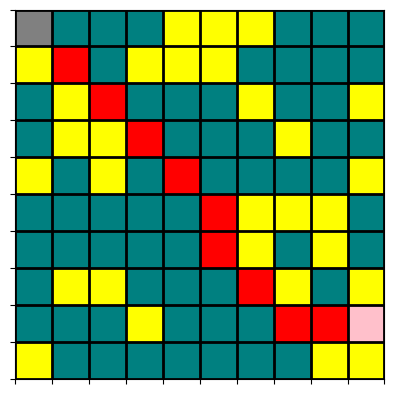

In [28]:
foo,cost = a_star(start, goal, edge_weights_1 , return_cost=True)
print(cost)
show_path(env, foo)

### 2(b)
Explain what benefits this algorithm has over bfs, dfs, and ucs, generally speaking, and how the results compare to your results for bfs and ucs implemented in Question 1.

This algorithum is a informed search. It doesnt simply travel to the lightest path but rather it uses a hueristics value to try and guess which path is going to be "shortest" with some amount of accuracy. Becuase of this to cuts down on run time and the amount of memory used becuase it is more likely to find the path on its first try. It also has a benifite of DFS and BFS because it finds the lowest cost path but finds it faster and cheaper then a uniform cost search.

## Problem 3 - Heuristics

For questions 3A, 3B, and 3C answer True or False and provide a brief explanation, or a counterexample where applicable.

### Part 3A. 
Depth-first search always expands at least as many nodes as A* search with an admissible heuristic.
FALSE: Depth first always has the possibility of nailing the path on its first shot. This means that there is a slim chance that Depth-first can expand less nodes then A*
### Part 3B. 
Uniform cost search always expands at least as many nodes as A* search with an admissible heuristic.
TRUE A* is a "sniffing" ability added to the Uniform cost code making it so that way at worst A* expands the same number as Uniform cost
### Part 3C. 
In the game of chess, in a single move, a rook can move any number of squares on a chessboard in a straight line, either vertically or horizontally, but cannot jump over other pieces. Manhattan distance is an admissible heuristic for the smallest number of moves required to move the rook from square A to square B.

False: To my understanding manhatten would not be able to deal with the rook moving a variable number of squares over the board. 
